In [1]:
!pip install category_encoders
!pip3 install xgboost
!pip3 install eli5
!pip3 install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from scipy.stats.distributions import uniform
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
df = pd.read_csv('/content/drive/MyDrive/S2_Project/churn.csv', index_col = 0)
df

,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.630000,53005.25,17.0,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.340000,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.160000,21027.00,22.0,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,11,53.270000,25239.56,6.0,567.660000,No,Yes,Yes,Unsolved,Poor Website,1
4,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,20,113.130000,24483.66,16.0,663.060000,No,Yes,Yes,Solved,Poor Website,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,46,F,6F51HFO,NaN,Basic Membership,2017-09-21,No,xxxxxxxx,Credit/Debit Card Offers,Desktop,Wi-Fi,04:14:05,2,-650.682759,27277.68,6.0,639.510000,No,Yes,Yes,No Information Available,No reason specified,1
36988,29,F,21KSM8Y,Town,Basic Membership,2016-06-27,No,xxxxxxxx,Without Offers,Smartphone,Wi-Fi,23:18:31,13,-638.123421,11069.71,28.0,527.990000,Yes,No,No,Not Applicable,Poor Customer Service,1
36989,23,F,XK1IM9H,NaN,Basic Membership,2016-09-11,Yes,CID3838,Gift Vouchers/Coupons,Desktop,Wi-Fi,03:50:25,12,154.940000,38127.56,Error,680.470000,No,Yes,Yes,Unsolved,Poor Website,1
36990,53,M,K6VTP1Z,Village,Platinum Membership,2017-06-15,No,xxxxxxxx,Gift Vouchers/Coupons,Smartphone,Mobile_Data,09:50:03,15,482.610000,2378.86,20.0,197.264414,Yes,Yes,No,Not Applicable,No reason specified,0


|Column name|Description|
|------|---|
|age|고객의 나이|
|gender|고객의 성별|
|security_no|개인 식별에 사용되는 고유 보안 번호|
|region_category|고객이 거주하는 지역 유형|
|membership_category|고객의 멤버쉽 유형|
|joining_date|가입 날짜|
|joined_through referral|고객이 추천코드 또는 추천인<br> ID를 통해 가입했는지 여부|
|referral_id|추천인 ID|
|preferred_offer types|고객이 선호하는 서비스 유형|
|medium_of operation|고객이 거래에 사용하는 운영매체|
|internet_option|고객이 사용하는 인터넷 서비스 유형|
|last_visit time|마지막 접속 시간|
|days_since last login|마지막 접속 이후 일 수|
|avg_time spent|고객이 웹 사이트에서 보낸 평균 시간|
|avg_transaction value|고객의 평균 거래 가치|
|avg_frequency login days|고객이 하루에 웹 사이트에 <br> 로그인한 횟수|
|points_in wallet|고객이 보유한 포인트|
|used_special discount|고객이 제공되는 특별 할인을 <br>사용했는지 여부|
|offer_application preference|고객이 제안을 선호하는지 여부|
|past_complaint|고객이 불만을 제기했는지 여부|
|complaint_status|고객이 제기한 불만 사항이 해결되었는지 여부|
|feedback|고객이 제공한 피드백|
|churn_risk score|이탈 여부|

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36992 entries, 0 to 36991
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   security_no                   36992 non-null  object 
 3   region_category               31564 non-null  object 
 4   membership_category           36992 non-null  object 
 5   joining_date                  36992 non-null  object 
 6   joined_through_referral       36992 non-null  object 
 7   referral_id                   36992 non-null  object 
 8   preferred_offer_types         36704 non-null  object 
 9   medium_of_operation           36992 non-null  object 
 10  internet_option               36992 non-null  object 
 11  last_visit_time               36992 non-null  object 
 12  days_since_last_login         36992 non-null  int64  
 13  a

In [8]:
df.isnull().sum()

age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df['security_no'].duplicated().sum()

0

In [11]:
df.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,0.540982
std,15.867412,228.819900,398.289149,19444.806226,194.063624,0.498324
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,0.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,0.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,1.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,1.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,1.000000


In [12]:
numerical_features = df.dtypes[df.dtypes != 'object'].index

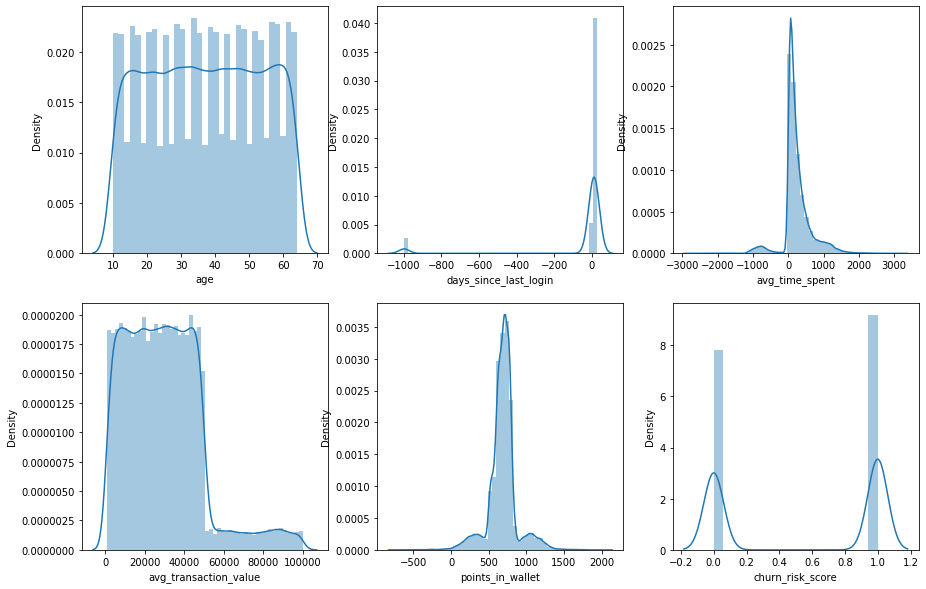

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, subplot in zip(numerical_features, ax.flatten()):
    sns.distplot(df[i], ax=subplot);

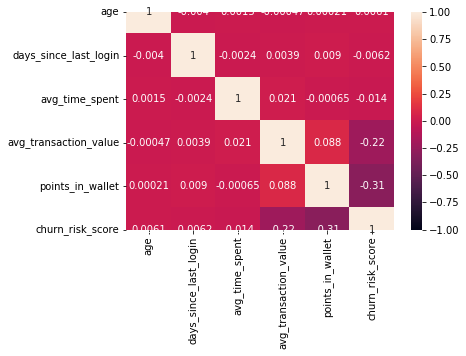

In [14]:
sns.heatmap(df.corr(), vmax=1, vmin=-1, annot=True)
plt.show()

In [15]:
'''df['churn_risk_score'] = df['churn_risk_score'].astype('object')
df['days_since_last_login'] = df['days_since_last_login'].replace(-999, np.nan)
df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors = 'coerce')
df['avg_time_spent'] = abs(df['avg_time_spent'])
df['avg_frequency_login_days'] = abs(df['avg_frequency_login_days'])
df['points_in_wallet'] = abs(df['points_in_wallet'])'''

"df['churn_risk_score'] = df['churn_risk_score'].astype('object')\ndf['days_since_last_login'] = df['days_since_last_login'].replace(-999, np.nan)\ndf['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors = 'coerce')\ndf['avg_time_spent'] = abs(df['avg_time_spent'])\ndf['avg_frequency_login_days'] = abs(df['avg_frequency_login_days'])\ndf['points_in_wallet'] = abs(df['points_in_wallet'])"

In [16]:
def engineer(df):
  df['prefer_coupon_used'] = ['Yes' if t else 'No' for t in list((df['preferred_offer_types'] == 'Gift Vouchers/Coupons') & (df['used_special_discount'] == 'Yes'))]
  #df['feedback_pos_neg'] = ['Pos' if t else 'Neg' for t in list((df['feedback'] == 'Reasonable Price') | (df['feedback'] == 'User Friendly Website')|(df['feedback'] == 'Products always in Stock')|(df['feedback'] == 'Quality Customer Care'))]
  dels = [col for col in df.columns if ('referral_id' in col or 'joining_date' in col or 'last_visit_time' in col or 'security_no' in col or 'feedback' in col)]
  df.drop(columns = dels, inplace = True)

  df['churn_risk_score'] = df['churn_risk_score'].astype('object')
  df['days_since_last_login'] = df['days_since_last_login'].replace(-999, np.nan)
  df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors = 'coerce')
  df['avg_time_spent'] = abs(df['avg_time_spent'])
  df['avg_frequency_login_days'] = abs(df['avg_frequency_login_days'])
  df['points_in_wallet'] = abs(df['points_in_wallet'])

  categorical_features = df.dtypes[df.dtypes == 'object'].index
  numerical_features = df.dtypes[df.dtypes != 'object'].index

  for i in numerical_features:
    if df[i].isnull().sum() > 0:
      df[i].fillna(df[i].median(),inplace=True)

  for i in categorical_features:
    df[i].fillna(df[i].mode()[0], inplace = True)

  return df, categorical_features, numerical_features


In [17]:
df, categorical_features, numerical_features = engineer(df)
df

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,prefer_coupon_used
0,18,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,?,Wi-Fi,17.0,300.630000,53005.25,17.0,781.750000,Yes,Yes,No,Not Applicable,0,Yes
1,32,F,City,Premium Membership,?,Gift Vouchers/Coupons,Desktop,Mobile_Data,16.0,306.340000,12838.38,10.0,697.630000,Yes,No,Yes,Solved,0,Yes
2,44,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14.0,516.160000,21027.00,22.0,500.690000,No,Yes,Yes,Solved in Follow-up,1,No
3,37,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11.0,53.270000,25239.56,6.0,567.660000,No,Yes,Yes,Unsolved,1,No
4,31,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20.0,113.130000,24483.66,16.0,663.060000,No,Yes,Yes,Solved,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,46,F,Town,Basic Membership,No,Credit/Debit Card Offers,Desktop,Wi-Fi,2.0,650.682759,27277.68,6.0,639.510000,No,Yes,Yes,No Information Available,1,No
36988,29,F,Town,Basic Membership,No,Without Offers,Smartphone,Wi-Fi,13.0,638.123421,11069.71,28.0,527.990000,Yes,No,No,Not Applicable,1,No
36989,23,F,Town,Basic Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,12.0,154.940000,38127.56,16.0,680.470000,No,Yes,Yes,Unsolved,1,No
36990,53,M,Village,Platinum Membership,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,15.0,482.610000,2378.86,20.0,197.264414,Yes,Yes,No,Not Applicable,0,Yes


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36992 entries, 0 to 36991
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   region_category               36992 non-null  object 
 3   membership_category           36992 non-null  object 
 4   joined_through_referral       36992 non-null  object 
 5   preferred_offer_types         36992 non-null  object 
 6   medium_of_operation           36992 non-null  object 
 7   internet_option               36992 non-null  object 
 8   days_since_last_login         36992 non-null  float64
 9   avg_time_spent                36992 non-null  float64
 10  avg_transaction_value         36992 non-null  float64
 11  avg_frequency_login_days      36992 non-null  float64
 12  points_in_wallet              36992 non-null  float64
 13  u

In [19]:
df.isnull().sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
churn_risk_score                0
prefer_coupon_used              0
dtype: int64

In [20]:
df.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,36992.000000,36992.000000,36992.000000
mean,37.118161,12.771599,314.822566,29271.194003,16.385015,689.104978,0.540982
std,15.867412,5.420212,344.671872,19444.806226,7.981398,180.227032,0.498324
min,10.000000,1.000000,1.837399,800.460000,0.006221,0.788907,0.000000
25%,23.000000,9.000000,75.427500,14177.540000,10.000000,624.365000,0.000000
50%,37.000000,13.000000,186.175000,27554.485000,16.000000,697.630000,1.000000
75%,51.000000,16.000000,416.155000,40855.110000,22.000000,757.010000,1.000000
max,64.000000,26.000000,3235.578521,99914.050000,73.061995,2069.069761,1.000000


In [21]:
'''for i in numerical_features:
  if df[i].isnull().sum() > 0:
    df[i].fillna(df[i].median(),inplace=True)

for i in categorical_features:
  df[i].fillna(df[i].mode()[0], inplace = True)'''

'for i in numerical_features:\n  if df[i].isnull().sum() > 0:\n    df[i].fillna(df[i].median(),inplace=True)\n\nfor i in categorical_features:\n  df[i].fillna(df[i].mode()[0], inplace = True)'

In [22]:
'''categorical_features = df.dtypes[df.dtypes == 'object'].index
numerical_features = df.dtypes[df.dtypes != 'object'].index'''

"categorical_features = df.dtypes[df.dtypes == 'object'].index\nnumerical_features = df.dtypes[df.dtypes != 'object'].index"

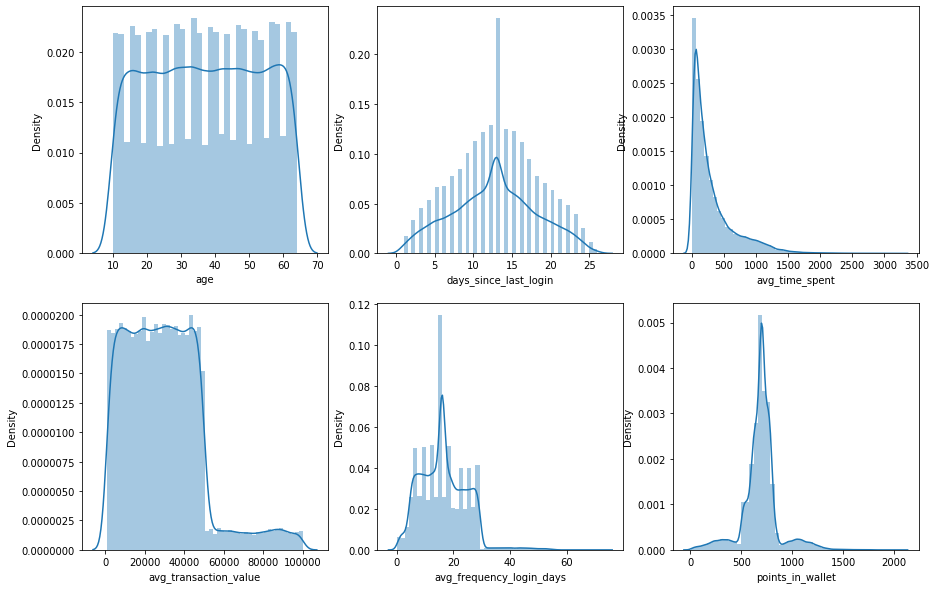

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, subplot in zip(numerical_features, ax.flatten()):
    sns.distplot(df[i], ax=subplot);

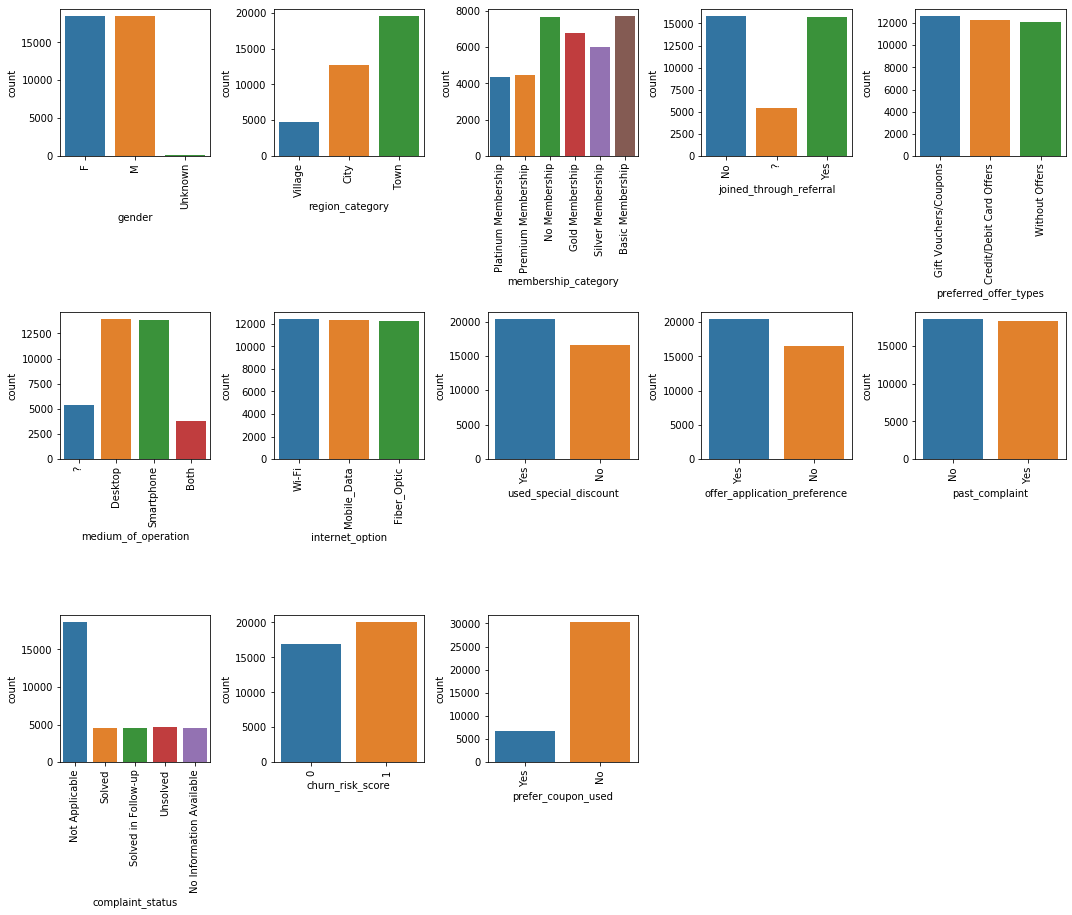

In [24]:
plt.figure(figsize=(15, 15))
for i in range(0, len(categorical_features)):
  plt.subplot(4, 5, i+1)
  g = sns.countplot(x=df[categorical_features[i]])
  g.set_xticklabels(g.get_xticklabels(),rotation=90)
  plt.tight_layout()

In [25]:
for i in categorical_features:
  print(df[i].value_counts())
  print()

F          18490
M          18443
Unknown       59
Name: gender, dtype: int64

Town       19556
City       12737
Village     4699
Name: region_category, dtype: int64

Basic Membership       7724
No Membership          7692
Gold Membership        6795
Silver Membership      5988
Premium Membership     4455
Platinum Membership    4338
Name: membership_category, dtype: int64

No     15839
Yes    15715
?       5438
Name: joined_through_referral, dtype: int64

Gift Vouchers/Coupons       12637
Credit/Debit Card Offers    12274
Without Offers              12081
Name: preferred_offer_types, dtype: int64

Desktop       13913
Smartphone    13876
?              5393
Both           3810
Name: medium_of_operation, dtype: int64

Wi-Fi          12413
Mobile_Data    12343
Fiber_Optic    12236
Name: internet_option, dtype: int64

Yes    20342
No     16650
Name: used_special_discount, dtype: int64

Yes    20440
No     16552
Name: offer_application_preference, dtype: int64

No     18602
Yes    18390
Nam

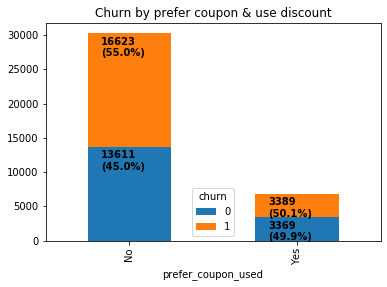

In [26]:
prefer_coupon_used_churn_prop = pd.crosstab(index=df['prefer_coupon_used'], columns=df['churn_risk_score'],normalize="index")
prefer_coupon_used_churn = pd.crosstab(index=df['prefer_coupon_used'], columns=df['churn_risk_score'])
prefer_coupon_used_churn.plot(kind = 'bar', stacked = 'true', title = "Churn by prefer coupon & use discount")
plt.legend(loc="lower center", title = 'churn')
for n, x in enumerate([*prefer_coupon_used_churn.index.values]):
    for (proportion, count, y_loc) in zip(prefer_coupon_used_churn_prop.loc[x],
                                          prefer_coupon_used_churn.loc[x],
                                          prefer_coupon_used_churn.loc[x].cumsum()):
                
        plt.text(x = n - 0.17,
                 y=(y_loc - proportion) + (proportion / 2) -3300,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=10,
                 fontweight="bold")
plt.show();

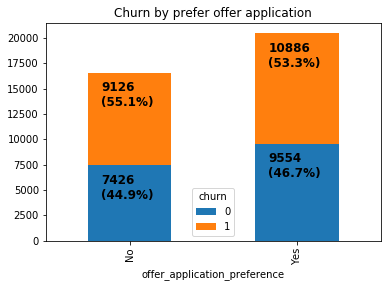

In [27]:
app_preference_churn_prop = pd.crosstab(index=df['offer_application_preference'], columns=df['churn_risk_score'],normalize="index")
app_preference_churn = pd.crosstab(index=df['offer_application_preference'], columns=df['churn_risk_score'])
app_preference_churn.plot(kind = 'bar', stacked = 'true', title = "Churn by prefer offer application")
plt.legend(loc="lower center", title = 'churn')
for n, x in enumerate([*app_preference_churn.index.values]):
    for (proportion, count, y_loc) in zip(app_preference_churn_prop.loc[x],
                                          app_preference_churn.loc[x],
                                          app_preference_churn.loc[x].cumsum()):
                
        plt.text(x = n - 0.17,
                 y=(y_loc - proportion) + (proportion / 2) -3300,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
plt.show()

In [28]:
'''feedback_churn_prop = pd.crosstab(index=df['feedback'], columns=df['churn_risk_score'],normalize="index")
feedback_churn = pd.crosstab(index=df['feedback'], columns=df['churn_risk_score'])
feedback_churn.plot(kind = 'bar', stacked = 'true', title = "Churn by special discount")
plt.legend(loc="upper center", title = 'churn')
for n, x in enumerate([*feedback_churn.index.values]):
    for (proportion, count, y_loc) in zip(feedback_churn_prop.loc[x],
                                          feedback_churn.loc[x],
                                          feedback_churn.loc[x].cumsum()):
                
        plt.text(x = n - 0.17,
                 y=(y_loc - proportion) + (proportion / 2)-500,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=5,
                 fontweight="bold")
plt.show()'''

'feedback_churn_prop = pd.crosstab(index=df[\'feedback\'], columns=df[\'churn_risk_score\'],normalize="index")\nfeedback_churn = pd.crosstab(index=df[\'feedback\'], columns=df[\'churn_risk_score\'])\nfeedback_churn.plot(kind = \'bar\', stacked = \'true\', title = "Churn by special discount")\nplt.legend(loc="upper center", title = \'churn\')\nfor n, x in enumerate([*feedback_churn.index.values]):\n    for (proportion, count, y_loc) in zip(feedback_churn_prop.loc[x],\n                                          feedback_churn.loc[x],\n                                          feedback_churn.loc[x].cumsum()):\n                \n        plt.text(x = n - 0.17,\n                 y=(y_loc - proportion) + (proportion / 2)-500,\n                 s=f\'{count}\n({np.round(proportion * 100, 1)}%)\', \n                 color="black",\n                 fontsize=5,\n                 fontweight="bold")\nplt.show()'

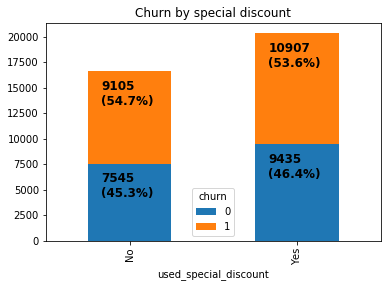

In [29]:
used_special_discount_churn_prop = pd.crosstab(index=df['used_special_discount'], columns=df['churn_risk_score'],normalize="index")
used_special_discount_churn = pd.crosstab(index=df['used_special_discount'], columns=df['churn_risk_score'])
used_special_discount_churn.plot(kind = 'bar', stacked = 'true', title = "Churn by special discount")
plt.legend(loc="lower center", title = 'churn')
for n, x in enumerate([*used_special_discount_churn.index.values]):
    for (proportion, count, y_loc) in zip(used_special_discount_churn_prop.loc[x],
                                          used_special_discount_churn.loc[x],
                                          used_special_discount_churn.loc[x].cumsum()):
                
        plt.text(x = n - 0.17,
                 y=(y_loc - proportion) + (proportion / 2) -3300,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
plt.show()

In [30]:
'''membership_churn = pd.crosstab(index=df['membership_category'], columns=df['churn_risk_score'])
membership_churn = membership_churn.sort_values(membership_churn.columns[0])
membership_churn.plot(kind = 'bar', stacked = 'true', title = "Churn by membership")
plt.legend(loc="upper right", title = 'churn')
plt.show()'''

'membership_churn = pd.crosstab(index=df[\'membership_category\'], columns=df[\'churn_risk_score\'])\nmembership_churn = membership_churn.sort_values(membership_churn.columns[0])\nmembership_churn.plot(kind = \'bar\', stacked = \'true\', title = "Churn by membership")\nplt.legend(loc="upper right", title = \'churn\')\nplt.show()'

In [31]:
'''feedback_np_churn = pd.crosstab(index=df['feedback_pos_neg'], columns=df['churn_risk_score'])
feedback_np_churn = feedback_np_churn.sort_values(feedback_np_churn.columns[0])
feedback_np_churn.plot(kind = 'bar', stacked = 'true', title = "Churn by feedback status")
plt.legend(loc="upper right", title = 'churn')
plt.show()'''

'feedback_np_churn = pd.crosstab(index=df[\'feedback_pos_neg\'], columns=df[\'churn_risk_score\'])\nfeedback_np_churn = feedback_np_churn.sort_values(feedback_np_churn.columns[0])\nfeedback_np_churn.plot(kind = \'bar\', stacked = \'true\', title = "Churn by feedback status")\nplt.legend(loc="upper right", title = \'churn\')\nplt.show()'

In [32]:
df.isnull().sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
churn_risk_score                0
prefer_coupon_used              0
dtype: int64

In [33]:
df_logistic = df.copy()

In [34]:
df_logistic["avg_time_spent"] = np.log1p(df_logistic["avg_time_spent"])
df_logistic["avg_transaction_value"] = np.log1p(df_logistic["avg_transaction_value"])
df_logistic["avg_frequency_login_days"] = np.log1p(df_logistic["avg_frequency_login_days"])
df_logistic["points_in_wallet"] = np.log1p(df_logistic["points_in_wallet"])

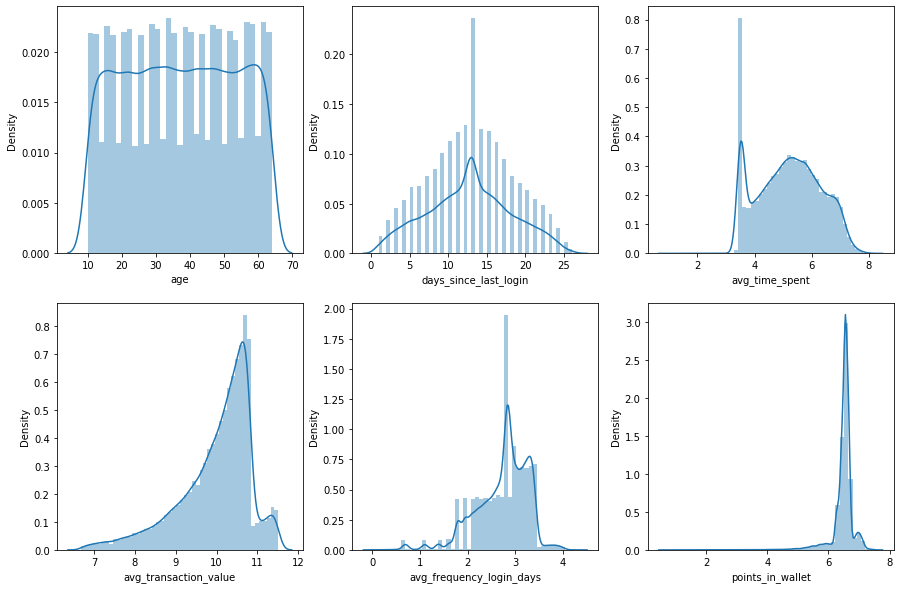

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, subplot in zip(numerical_features, ax.flatten()):
    sns.distplot(df_logistic[i], ax=subplot);

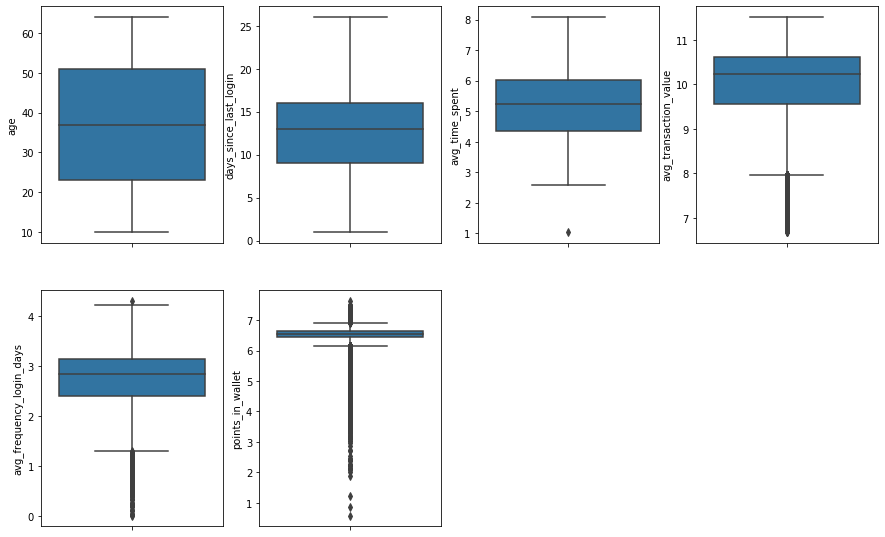

In [36]:
plt.figure(figsize = (15, 20))
for i in range(len(numerical_features)):
  plt.subplot(4, 4, i+1)
  sns.boxplot(y = df_logistic[numerical_features[i]]);

In [37]:
for i in numerical_features:
  Q1,Q3 = np.percentile(df_logistic[i],[25,75])
  IQR = Q3 - Q1
  lr = Q1 - (1.5 * IQR)
  ur = Q3 + (1.5 * IQR)
  outlier_index = df_logistic[(df_logistic[i] < lr) | (df_logistic[i] > ur)].index
  df_logistic = df_logistic.drop(df_logistic.index[outlier_index]).reset_index(drop = True)

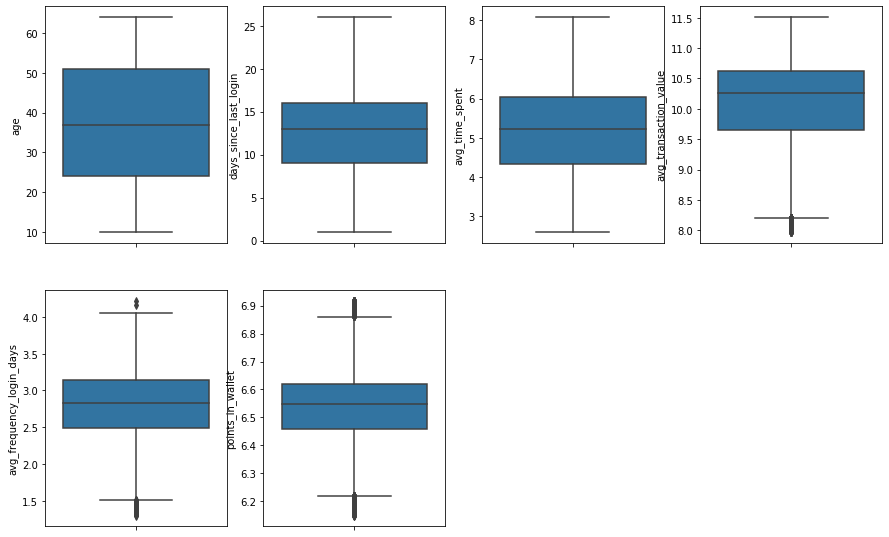

In [38]:
plt.figure(figsize = (15, 20))
for i in range(len(numerical_features)):
  plt.subplot(4, 4, i+1)
  sns.boxplot(y = df_logistic[numerical_features[i]]);

In [39]:
X_logistic = df_logistic.drop(columns = 'churn_risk_score',axis = 1)
y_logistic = df_logistic['churn_risk_score']

X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic = train_test_split(X_logistic, y_logistic, test_size=0.2, random_state=42)
X_train_logistic, X_val_logistic, y_train_logistic, y_val_logistic = train_test_split(X_train_logistic, y_train_logistic, test_size=0.2, random_state=42)

In [40]:
X_train_logistic.shape, X_val_logistic.shape, X_test_logistic.shape, y_train_logistic.shape, y_val_logistic.shape, y_test_logistic.shape,

((19513, 18), (4879, 18), (6098, 18), (19513,), (4879,), (6098,))

In [41]:
y_train_logistic.value_counts(normalize = True)

1    0.54579
0    0.45421
Name: churn_risk_score, dtype: float64

||기준모델점수|f1 score|
|----|-----|-----|
|로지스틱회귀|0.706|0.928|
|랜덤포레스트|0.7|0.934|
|XGBoost|0.7|0.94|


In [42]:
base = [y_train_logistic.mode()[0]] * len(y_train_logistic)
print('로지스틱회귀 기준모델 점수:', f1_score(y_train_logistic, base).round(3))

로지스틱회귀 기준모델 점수: 0.706


In [43]:
scaler = StandardScaler()
X_train_logistic[numerical_features] = scaler.fit_transform(X_train_logistic[numerical_features])
X_val_logistic[numerical_features] = scaler.transform(X_val_logistic[numerical_features])
X_test_logistic[numerical_features] = scaler.transform(X_test_logistic[numerical_features])

In [44]:
ohe = OneHotEncoder(cols = X_train_logistic.dtypes[X_train_logistic.dtypes == 'object'].index, use_cat_names = True)
X_train_logistic = ohe.fit_transform(X_train_logistic)
X_val_logistic = ohe.transform(X_val_logistic)
X_test_logistic = ohe.transform(X_test_logistic)

In [45]:
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(X_train_logistic, y_train_logistic)
y_val_pred = logistic.predict(X_val_logistic)
print('logistic train accuracy', logistic.score(X_train_logistic, y_train_logistic).round(3))
print("logistic validation f1 score: ", f1_score(y_val_logistic, y_val_pred).round(3))

logistic train accuracy 0.905
logistic validation f1 score:  0.907


In [46]:
print('회귀계수가 양수인 특성 상위 3개')
print(pd.Series(logistic.coef_[0], logistic.feature_names_in_).sort_values(ascending=False).head(15), '\n')
print('회귀계수가 음수인 특성 하위 개')
print(pd.Series(logistic.coef_[0], logistic.feature_names_in_).sort_values().head(15))

회귀계수가 양수인 특성 상위 3개
membership_category_No Membership            4.196457
membership_category_Basic Membership         4.108233
membership_category_Silver Membership        0.827772
membership_category_Gold Membership          0.669560
avg_frequency_login_days                     0.147338
preferred_offer_types_Without Offers         0.137474
gender_M                                     0.104953
gender_F                                     0.094004
joined_through_referral_?                    0.087514
medium_of_operation_Smartphone               0.072685
complaint_status_No Information Available    0.059637
region_category_City                         0.052862
offer_application_preference_No              0.048116
prefer_coupon_used_Yes                       0.038277
internet_option_Fiber_Optic                  0.035111
dtype: float64 

회귀계수가 음수인 특성 하위 개
membership_category_Premium Membership           -4.914886
membership_category_Platinum Membership          -4.886066
points_in_wallet  

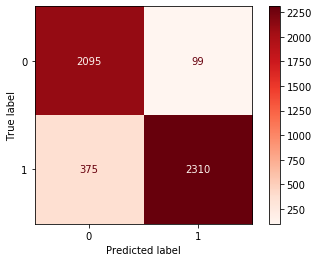

In [47]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(logistic, X_val_logistic, y_val_logistic,
                            cmap=plt.cm.Reds,
                            ax=ax)
plt.show();

In [48]:
y_val_proba = logistic.predict_proba(X_val_logistic)[:,1]
auc = roc_auc_score(y_val_logistic, y_val_proba).round(3)
auc

0.967

In [49]:
print(classification_report(y_val_logistic, y_val_pred))
print('f1 score: ',f1_score(y_val_logistic, y_val_pred).round(3))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      2194
           1       0.96      0.86      0.91      2685

    accuracy                           0.90      4879
   macro avg       0.90      0.91      0.90      4879
weighted avg       0.91      0.90      0.90      4879

f1 score:  0.907


In [50]:
X_rf = df.drop(columns = 'churn_risk_score',axis = 1)
y_rf = df['churn_risk_score']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_train_rf, y_train_rf, test_size=0.2, random_state=42)

In [51]:
base = [y_train_rf.mode()[0]] * len(y_train_rf)
print('랜덤포레스트 기준모델 점수:', f1_score(y_train_rf, base))

랜덤포레스트 기준모델 점수: 0.700480307396734


In [52]:
pipe_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1),
)

pipe_rf.fit(X_train_rf, y_train_rf)
print("훈련 정확도: ", pipe_rf.score(X_train_rf, y_train_rf))
print("검증 정확도: ", pipe_rf.score(X_val_rf, y_val_rf))


훈련 정확도:  1.0
검증 정확도:  0.9263389085994256


In [53]:
y_val_pred_rf = pipe_rf.predict(X_val_rf)
print(classification_report(y_val_rf, y_val_pred_rf))
print('f1 score: ',f1_score(y_val_rf, y_val_pred_rf).round(3))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2690
           1       0.93      0.94      0.93      3229

    accuracy                           0.93      5919
   macro avg       0.93      0.93      0.93      5919
weighted avg       0.93      0.93      0.93      5919

f1 score:  0.933


In [54]:
y_val_proba_rf = pipe_rf.predict_proba(X_val_rf)[:,1]
auc = roc_auc_score(y_val_rf, y_val_proba_rf).round(3)
auc

0.971

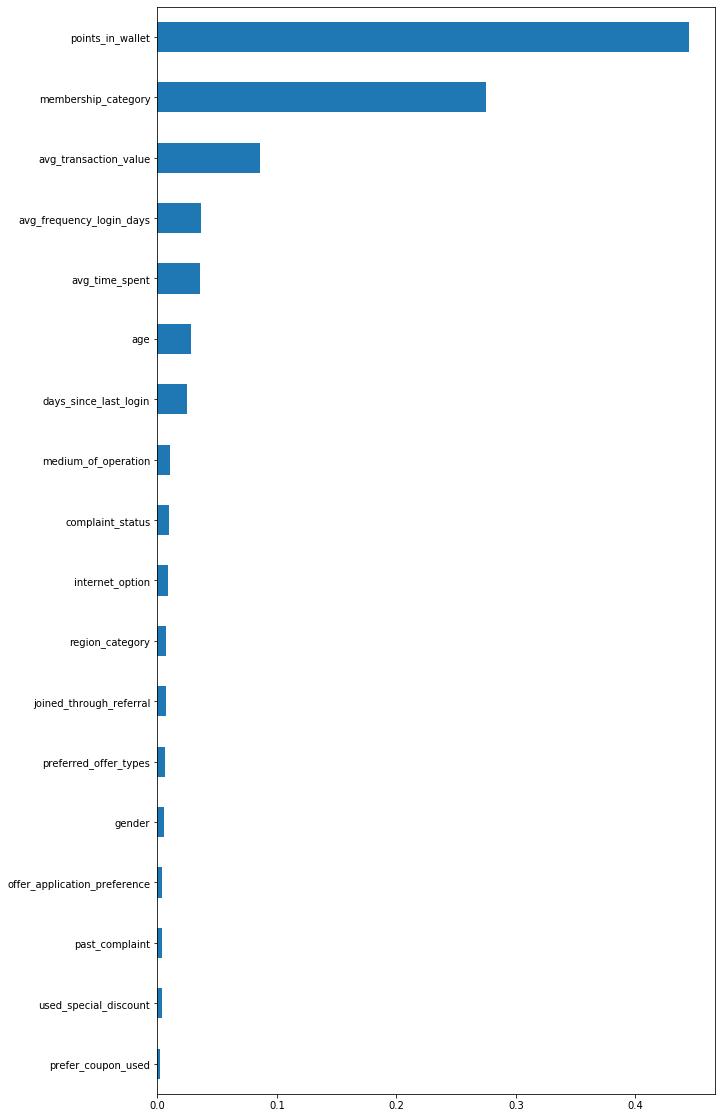

In [55]:
model_rf = pipe_rf.named_steps['randomforestclassifier']
importances = pd.Series(model_rf.feature_importances_, X_train_rf.columns)
plt.figure(figsize=(10, 20))
importances.sort_values().plot.barh();

In [56]:
X_xgb = df.drop(columns = 'churn_risk_score',axis = 1)
y_xgb = df['churn_risk_score']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train_xgb, y_train_xgb, test_size=0.2, random_state=42)

In [57]:
base = [y_train_xgb.mode()[0]] * len(y_train_xgb)
f1_score(y_train_xgb, base).round(3)

0.7

In [58]:
pipe_xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
    ),
)

pipe_xgb.fit(X_train_xgb, y_train_xgb)
print("훈련 정확도: ", pipe_rf.score(X_train_xgb, y_train_xgb))
print("검증 정확도: ", pipe_rf.score(X_val_xgb, y_val_xgb))


훈련 정확도:  1.0
검증 정확도:  0.9263389085994256


In [59]:
y_val_pred_xgb = pipe_xgb.predict(X_val_xgb)
y_val_proba_xgb = pipe_xgb.predict_proba(X_val_xgb)[:,1]
auc = roc_auc_score(y_val_xgb, y_val_proba_xgb)
print(classification_report(y_val_xgb, y_val_pred_xgb))
print('f1 score: ',f1_score(y_val_xgb, y_val_pred_xgb))
print('auc score:',auc)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2690
           1       0.94      0.94      0.94      3229

    accuracy                           0.93      5919
   macro avg       0.93      0.93      0.93      5919
weighted avg       0.93      0.93      0.93      5919

f1 score:  0.9371995658241589
auc score: 0.972216817618216


In [60]:
y_val_proba_xgb = pipe_xgb.predict_proba(X_val_xgb)[:,1]
auc = roc_auc_score(y_val_xgb, y_val_proba_xgb).round(3)
print('auc score:',auc)

auc score: 0.972


In [61]:
permuter = PermutationImportance(
    pipe_xgb.named_steps["xgbclassifier"], 
    scoring = "f1",
    n_iter = 10,  
    random_state = 42,
)

X_test_preprocessed = pipe_xgb[0].transform(X_test_xgb)
permuter.fit(X_test_preprocessed, y_test_xgb)

PermutationImportance(estimator=XGBClassifier(eval_metric='error',
                                              n_estimators=200, n_jobs=-1,
                                              random_state=42),
                      n_iter=10, random_state=42, scoring='f1')

Text(0.5, 1.0, 'Permutation Importance')

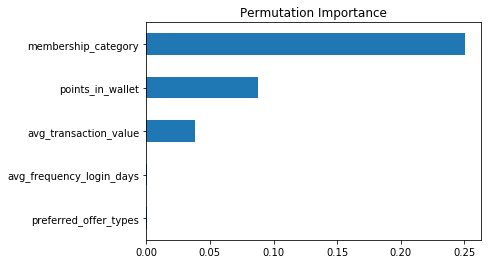

In [62]:
feature_names = X_test_xgb.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values().tail()
pi.plot.barh()
plt.title("Permutation Importance")

In [63]:
eli5.show_weights(
    permuter,
    top = None,  
    feature_names = feature_names, 
)

Weight,Feature
0.2505 ± 0.0049,membership_category
0.0877 ± 0.0051,points_in_wallet
0.0385 ± 0.0032,avg_transaction_value
0.0009 ± 0.0016,avg_frequency_login_days
0.0005 ± 0.0014,preferred_offer_types
0.0003 ± 0.0006,joined_through_referral
0.0003 ± 0.0005,gender
0.0001 ± 0.0005,medium_of_operation
0.0001 ± 0.0010,avg_time_spent
0.0001 ± 0.0010,age


In [64]:
X_xgb = df.drop(columns = 'churn_risk_score',axis = 1)
y_xgb = df['churn_risk_score']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train_xgb, y_train_xgb, test_size=0.2, random_state=42)

In [65]:
X_train_xgb.shape, X_val_xgb.shape, X_test_xgb.shape ,y_train_xgb.shape

((23674, 18), (5919, 18), (7399, 18), (23674,))

In [66]:
y_train_xgb.value_counts(normalize = True)

1    0.53903
0    0.46097
Name: churn_risk_score, dtype: float64

In [67]:
pipe_xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
    ),
)

pipe_xgb.fit(X_train_xgb, y_train_xgb)
print("훈련 정확도: ", pipe_xgb.score(X_train_xgb, y_train_xgb))
print("검증 정확도: ", pipe_xgb.score(X_val_xgb, y_val_xgb))

훈련 정확도:  0.9410745966038693
검증 정확도:  0.9315762797769893


In [68]:
params_xgb = {
    "xgbclassifier__max_depth": [4, 6, 8, 10],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__learning_rate":[0.05, 0.1, 0.15, 0.2],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ),
}

In [69]:
randomized_search = RandomizedSearchCV(
    pipe_xgb,
    param_distributions = params_xgb,
    scoring="f1",
    n_iter = 10,
    cv = 3,
    verbose = 1,
    random_state = 42,
)
randomized_search.fit(X_train_xgb, y_train_xgb)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['gender',
                                                                   'region_category',
                                                                   'membership_category',
                                                                   'joined_through_referral',
                                                                   'preferred_offer_types',
                                                                   'medium_of_operation',
                                                                   'internet_option',
                                                                   'used_special_discount',
                                                                   'offer_application_preference',
                                                                   'past_complaint',
                    

In [70]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 F1 score: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__colsample_bytree': 0.8898455001363846, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 4}
최적 F1 score:  0.9374368462056536


In [71]:
y_val_pred = randomized_search.predict(X_val_xgb)
print(classification_report(y_val_xgb, y_val_pred))
print('f1 score: ',f1_score(y_val_xgb, y_val_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2690
           1       0.93      0.94      0.94      3229

    accuracy                           0.93      5919
   macro avg       0.93      0.93      0.93      5919
weighted avg       0.93      0.93      0.93      5919

f1 score:  0.9373079287031346


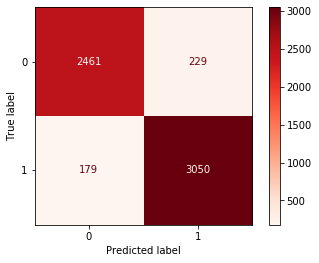

In [72]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(randomized_search, X_val_xgb, y_val_xgb,
                            cmap=plt.cm.Reds,
                            ax=ax)
plt.show();

In [73]:
y_test_pred = randomized_search.predict(X_test_xgb)
y_test_pred_proba = randomized_search.predict_proba(X_test_xgb)[:,1]
print('Test f1 score:',f1_score(y_test_xgb, y_test_pred))
print('Test AUC score:',roc_auc_score(y_test_xgb,y_test_pred_proba))

Test f1 score: 0.9393414211438474
Test AUC score: 0.9757483897786338


In [74]:
mappings = pipe_xgb[0].mapping

In [75]:
X_val_encoded = pipe_xgb[0].transform(X_val_xgb)

In [76]:
plt.rcParams["figure.dpi"] = 144

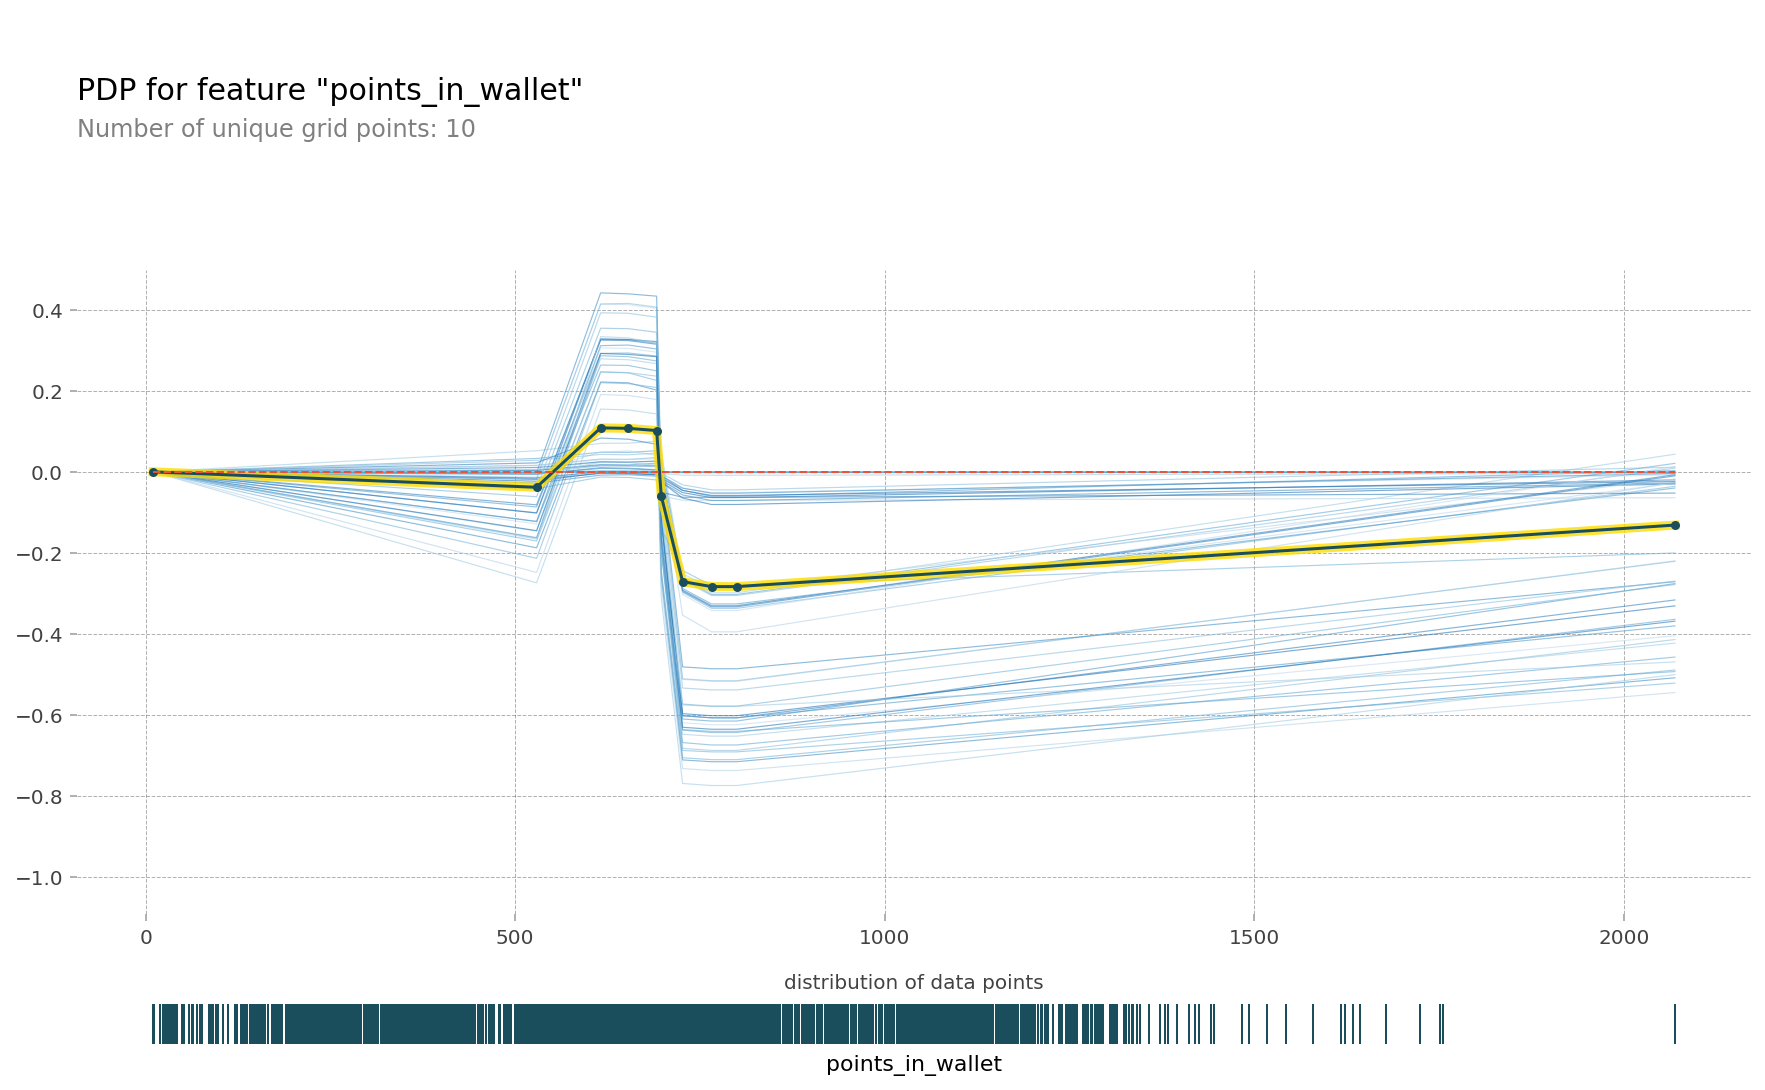

In [77]:
feature = 'points_in_wallet'
features = X_val_encoded.columns
pdp_dist = pdp_isolate(model = pipe_xgb[1], dataset = X_val_encoded, model_features = features, feature = feature)
pdp_plot(pdp_dist, feature, plot_lines = True, plot_pts_dist = True, frac_to_plot=50,);

In [78]:
mapping_data = list(filter(lambda x: x["col"] == 'prefer_coupon_used', mappings))
print(mapping_data)
maps = mapping_data[0]["mapping"]
print(type(maps))
print(maps)

[{'col': 'prefer_coupon_used', 'mapping': Yes    1
No     2
NaN   -2
dtype: int64, 'data_type': dtype('O')}]
<class 'pandas.core.series.Series'>
Yes    1
No     2
NaN   -2
dtype: int64


([<matplotlib.axis.XTick at 0x7faf8ddabe90>,
 <a list of 2 Text xticklabel objects>)

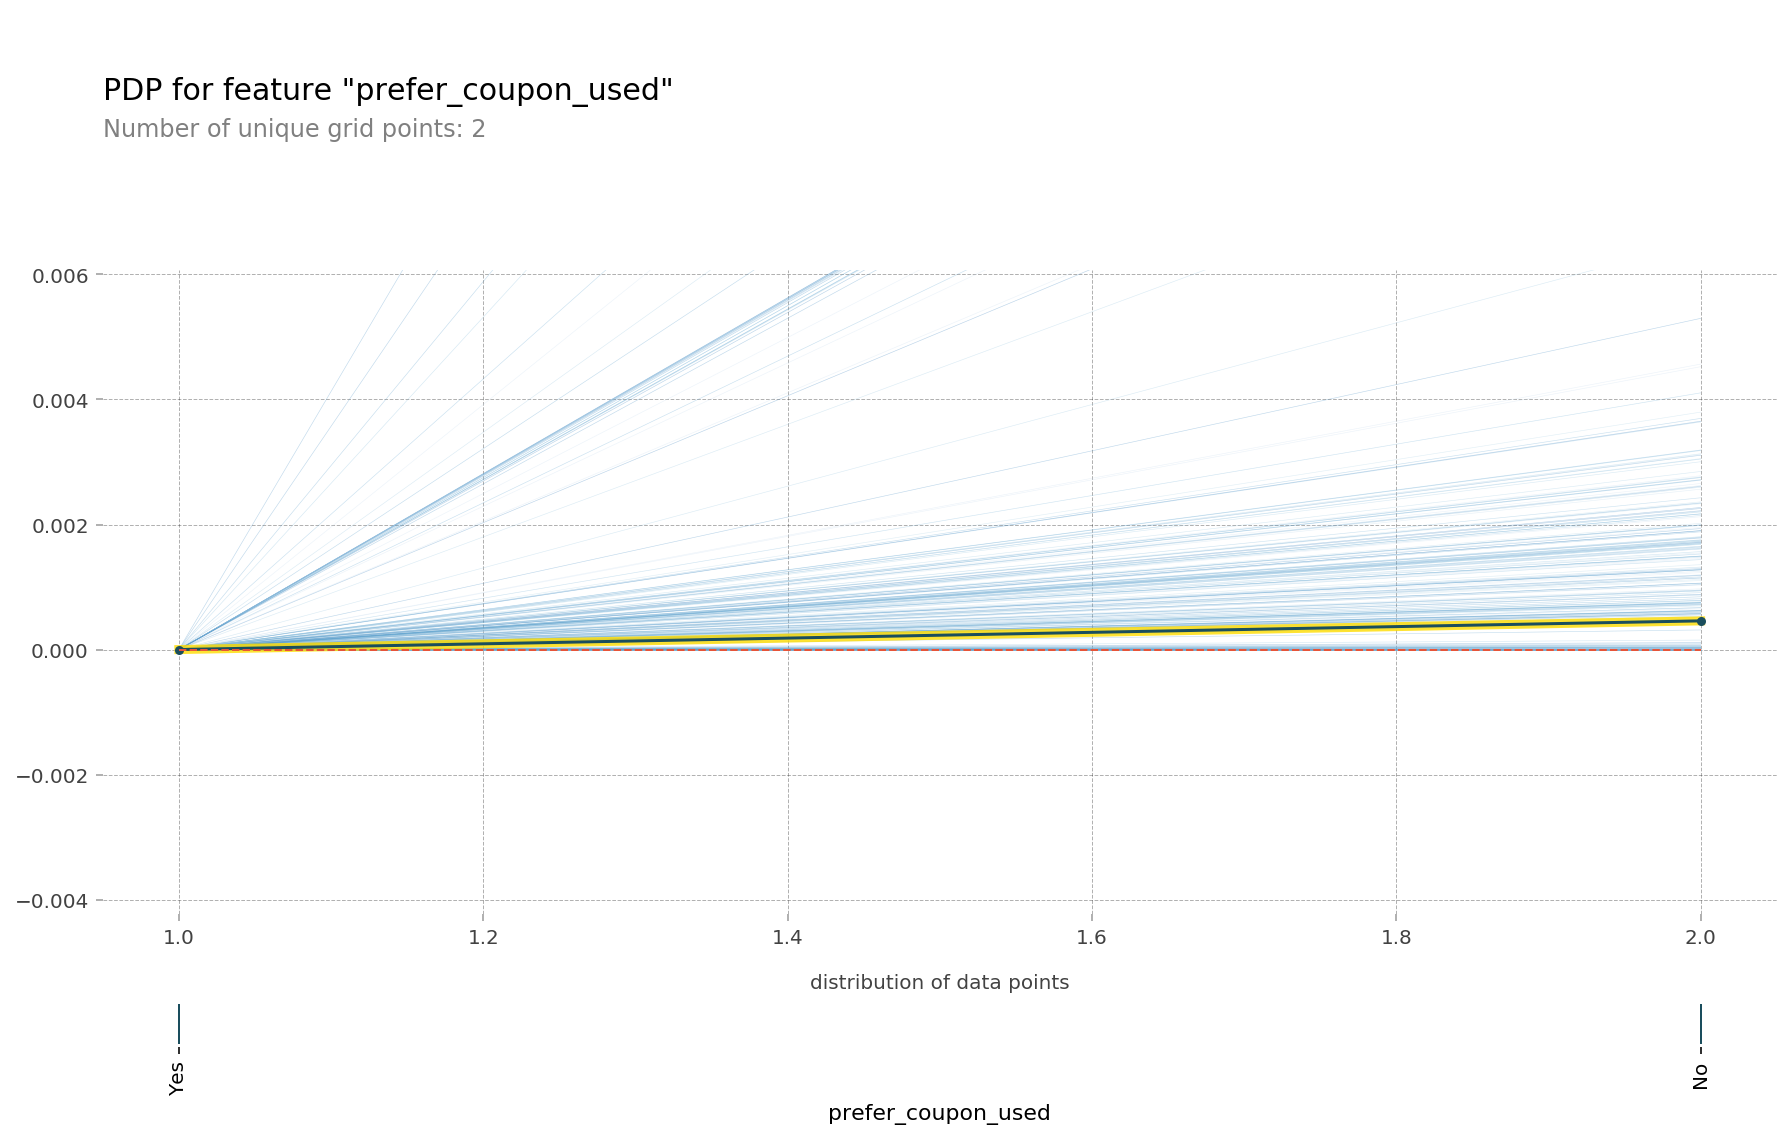

In [79]:
feature = 'prefer_coupon_used'
features = X_val_encoded.columns
pdp_dist = pdp_isolate(model = pipe_xgb[1], dataset = X_val_encoded, model_features = features, feature = feature, grid_type="percentile")
pdp_plot(pdp_dist, feature, plot_lines = True, plot_pts_dist = True, frac_to_plot=0.3);
encoded_features = maps.values.tolist()[:-1]
original_features = maps.index.tolist()[:-1]
plt.xticks(encoded_features, original_features, rotation=90)

In [84]:
mapping_data = list(filter(lambda x: x["col"] == 'membership_category', mappings))
print(mapping_data)
maps = mapping_data[0]["mapping"]
print(type(maps))
print(maps)

[{'col': 'membership_category', 'mapping': Basic Membership       1
Premium Membership     2
No Membership          3
Silver Membership      4
Gold Membership        5
Platinum Membership    6
NaN                   -2
dtype: int64, 'data_type': dtype('O')}]
<class 'pandas.core.series.Series'>
Basic Membership       1
Premium Membership     2
No Membership          3
Silver Membership      4
Gold Membership        5
Platinum Membership    6
NaN                   -2
dtype: int64


([<matplotlib.axis.XTick at 0x7faf84c76850>,
 <a list of 6 Text xticklabel objects>)

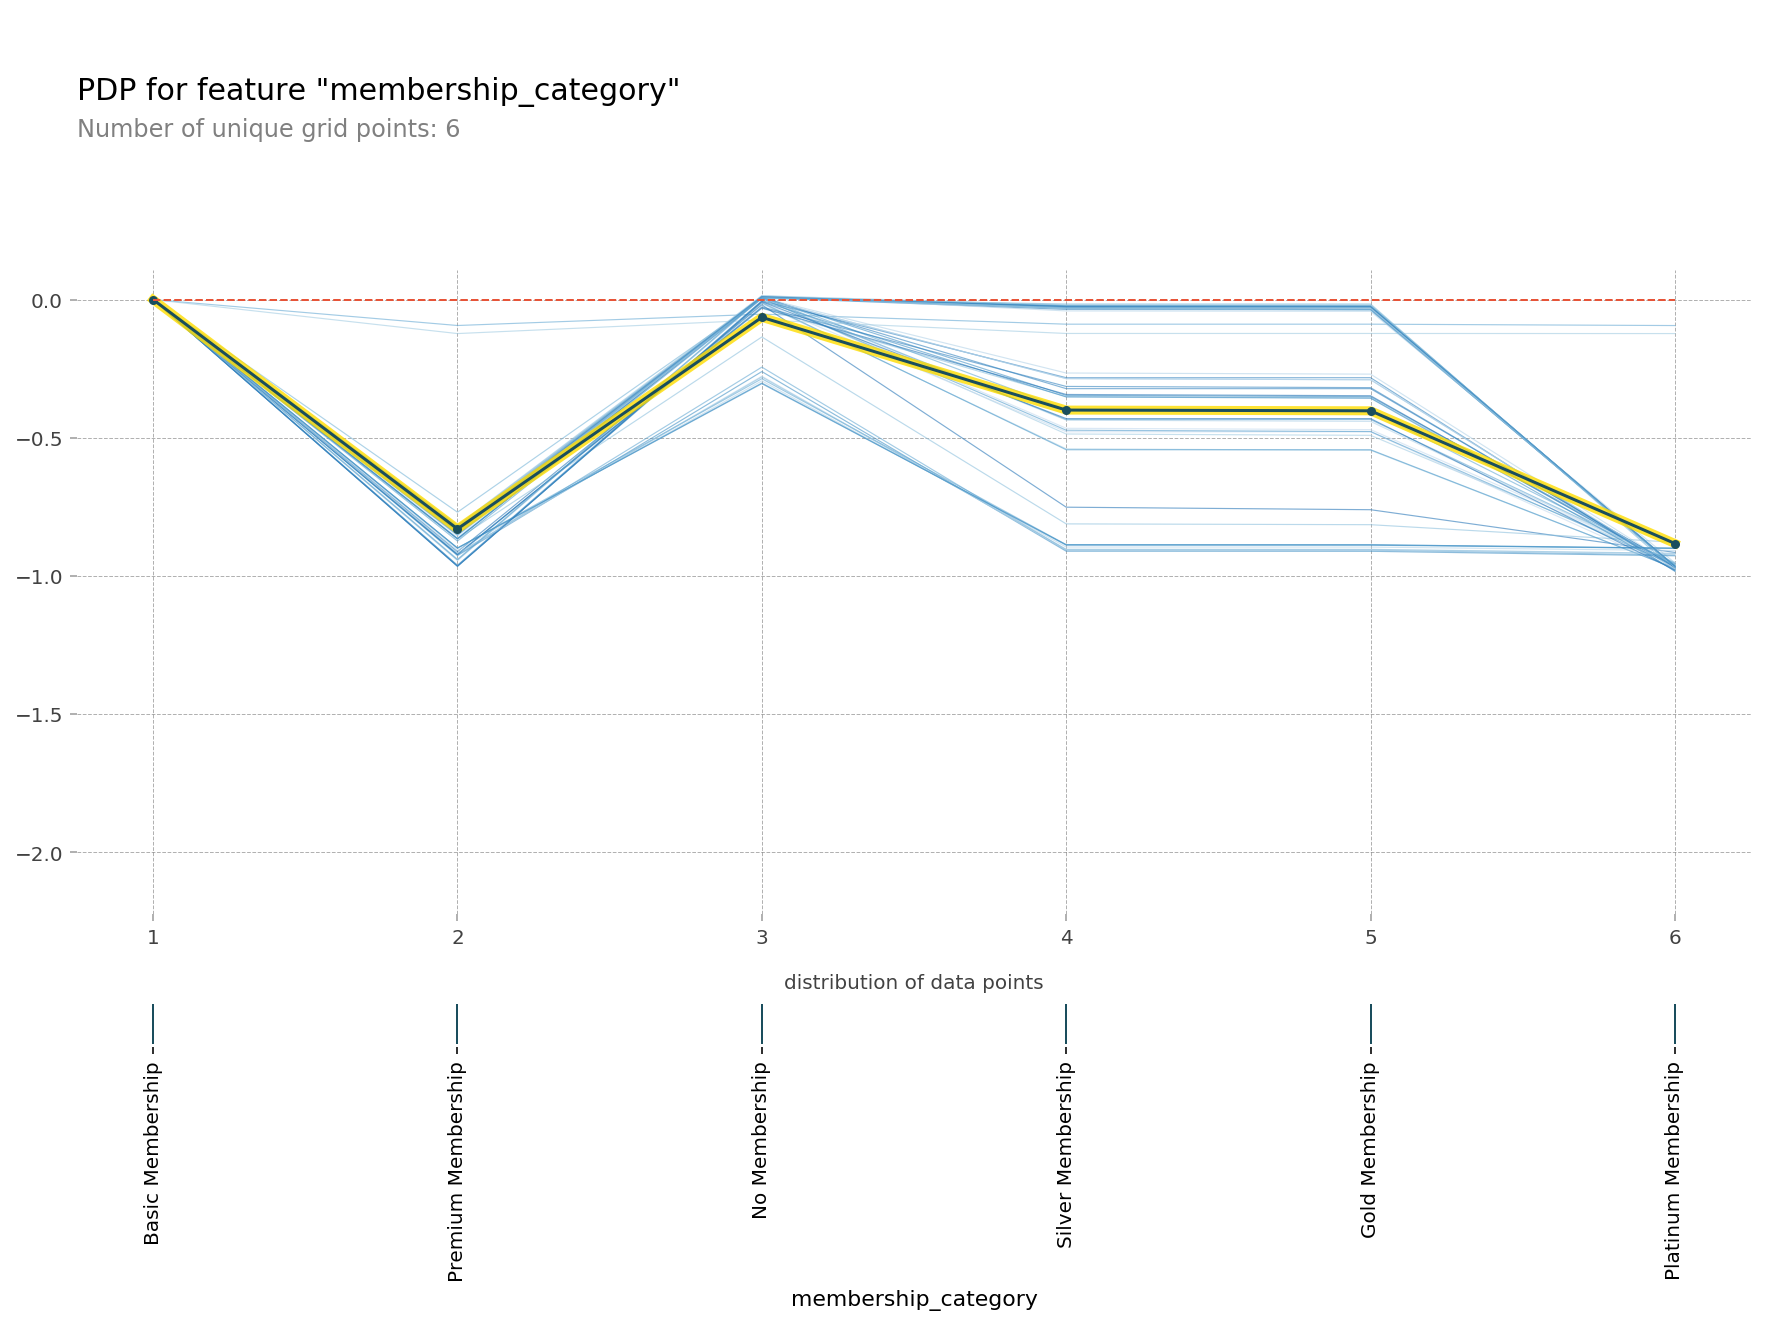

In [85]:
feature = 'membership_category'
features = X_val_encoded.columns
pdp_dist = pdp_isolate(model = pipe_xgb[1], dataset = X_val_encoded, model_features = features, feature = feature, cust_grid_points = [ 1, 2, 3, 4, 5, 6],)
pdp_plot(pdp_dist, feature, plot_lines = True, plot_pts_dist = True, frac_to_plot=50);
encoded_features = maps.values.tolist()[:-1]
original_features = maps.index.tolist()[:-1]
plt.xticks(encoded_features, original_features, rotation=90)

In [82]:
'''mapping_data = list(filter(lambda x: x["col"] == 'feedback', mappings))
print(mapping_data)
maps = mapping_data[0]["mapping"]
print(type(maps))
print(maps)'''

'mapping_data = list(filter(lambda x: x["col"] == \'feedback\', mappings))\nprint(mapping_data)\nmaps = mapping_data[0]["mapping"]\nprint(type(maps))\nprint(maps)'

In [83]:
'''feature = 'feedback_pos_neg'
features = X_val_encoded.columns
pdp_dist = pdp_isolate(model = pipe_xgb[1], dataset = X_val_encoded, model_features = features, feature = feature)
pdp_plot(pdp_dist, feature, plot_lines = True, plot_pts_dist = True, frac_to_plot=50);
encoded_features = maps.values.tolist()[:-1]
original_features = maps.index.tolist()[:-1]
plt.xticks(encoded_features, original_features, rotation=90)'''

"feature = 'feedback_pos_neg'\nfeatures = X_val_encoded.columns\npdp_dist = pdp_isolate(model = pipe_xgb[1], dataset = X_val_encoded, model_features = features, feature = feature)\npdp_plot(pdp_dist, feature, plot_lines = True, plot_pts_dist = True, frac_to_plot=50);\nencoded_features = maps.values.tolist()[:-1]\noriginal_features = maps.index.tolist()[:-1]\nplt.xticks(encoded_features, original_features, rotation=90)"